### Stochastic Weight Averaging (SWA)

- SWA has been shown to significantly improve generalization in computer vision tasks, including VGG, ResNets, Wide ResNets and DenseNets on ImageNet and CIFAR benchmarks.
- SWA performs an equal average of the weights traversed by SGD with a modified learning rate schedule (see the left panel of Figure 1.). **SWA solutions end up in the center of a wide flat region of loss, while SGD tends to converge to the boundary of the low-loss region, making it susceptible to the shift between train and test error surfaces.**

- Tranditional averaged SGD is often employed in conjunction with a decaying learning rate, and an exponentially moving average, typically for convex optimization. In convex optimization, the focus has been on improved rates of convergence. In deep learning, this form of averaged SGD smooths the trajectory of SGD iterates, but does not perform very differently.

- By contrast, SWA is focused on an **equal average** of SGD iterates with a modified **cyclical or high constant learning rate**, and exploits the flatness of training objectives specific to deep learning for improved generalization.

#### How it works?

1. First, SWA uses a modified learning rate schedule so that SGD continues to explore the set of high-performing networks instead of simply converging to a single solution. 
    - For example, we can use the standard decaying learning rate strategy for the first 75% of training time, and then set the learning rate to a reasonably high constant value for the remaining 25% of the time.
2. The second ingredient is to average the weights of the networks traversed by SGD. For example, we can maintain a running average of the weights obtained in the end of every epoch within the last 25% of training time.

#### Intuitions

- We can interpret points proposed by SGD as being constrained to the surface of a sphere, since they come from a high dimensional Gaussian distribution. Thus, by averaging them, SWA effectively allows us to go inside the sphere to find higher density solutions.

-  The train loss and test error surfaces are qualitatively similar, they are not perfectly aligned. It is safer to have a more centred solution in **a flatter region of the training loss.**

- SWA is not finding a different minima than SGD, but rather a flatter region in the same basin of attraction.

<img src =attachment:image.png width=450>
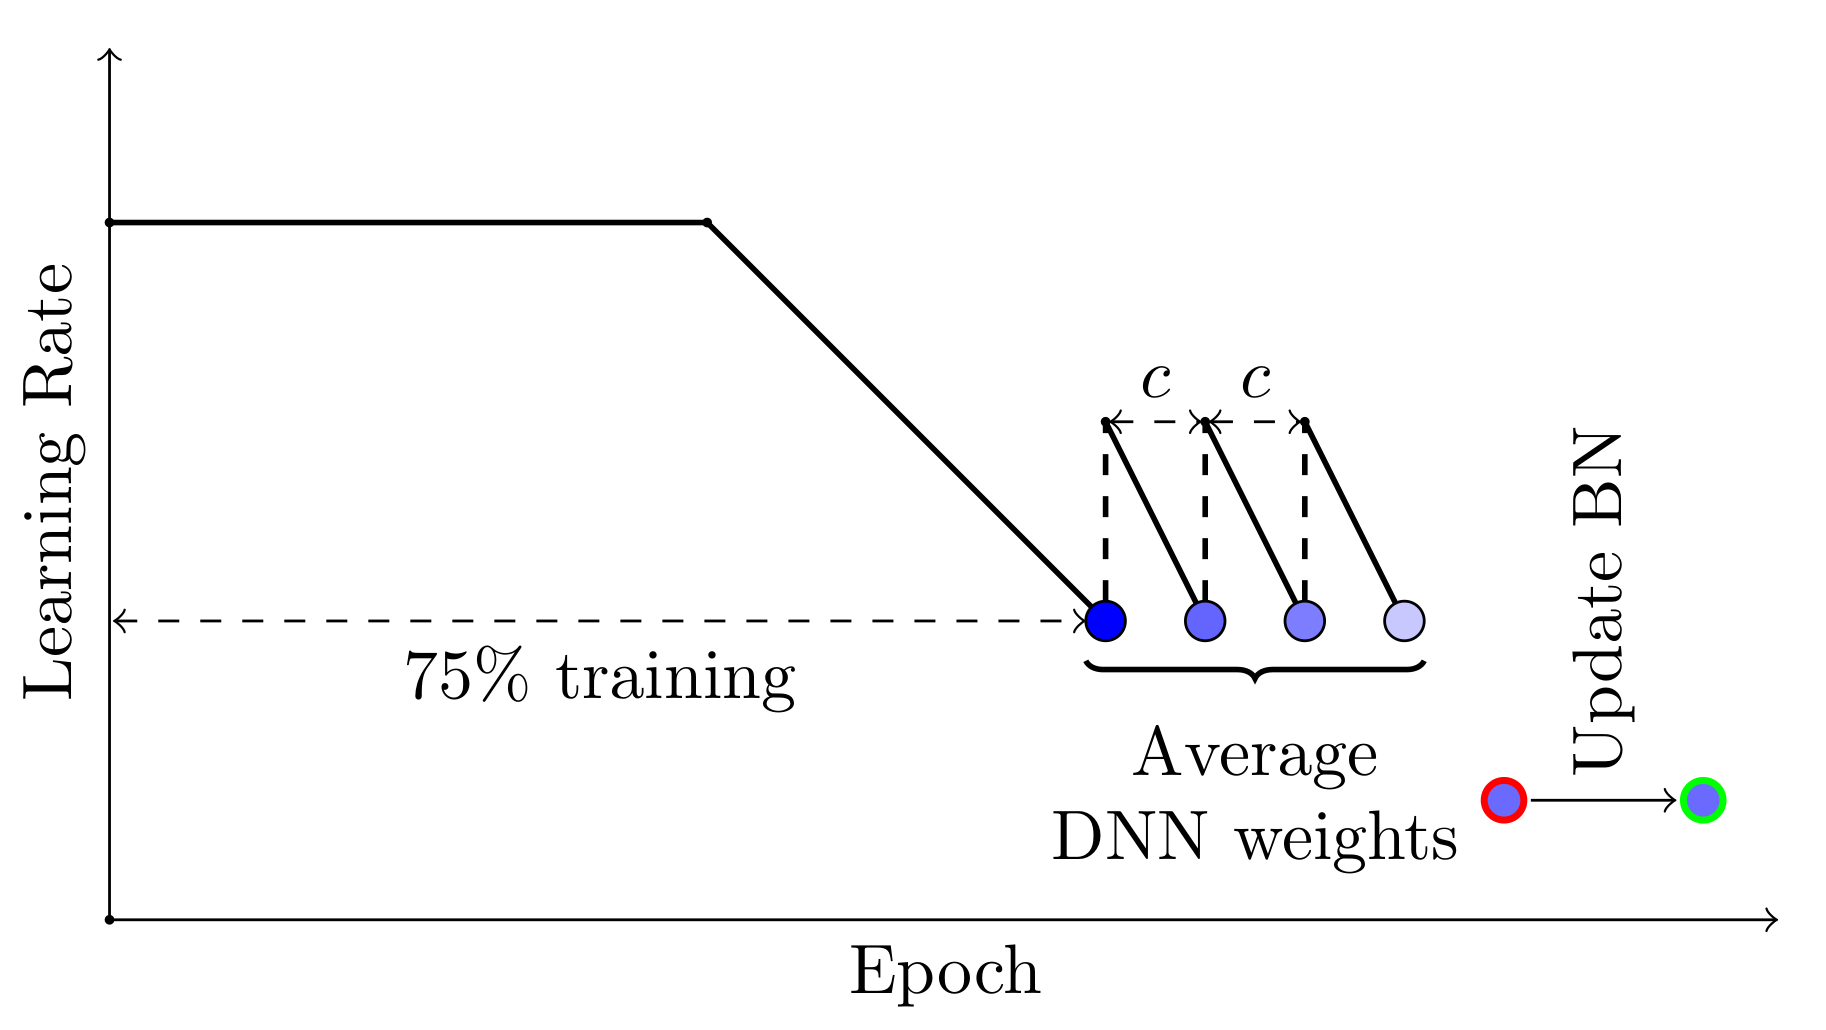

<img src=attachment:image.png width=450>
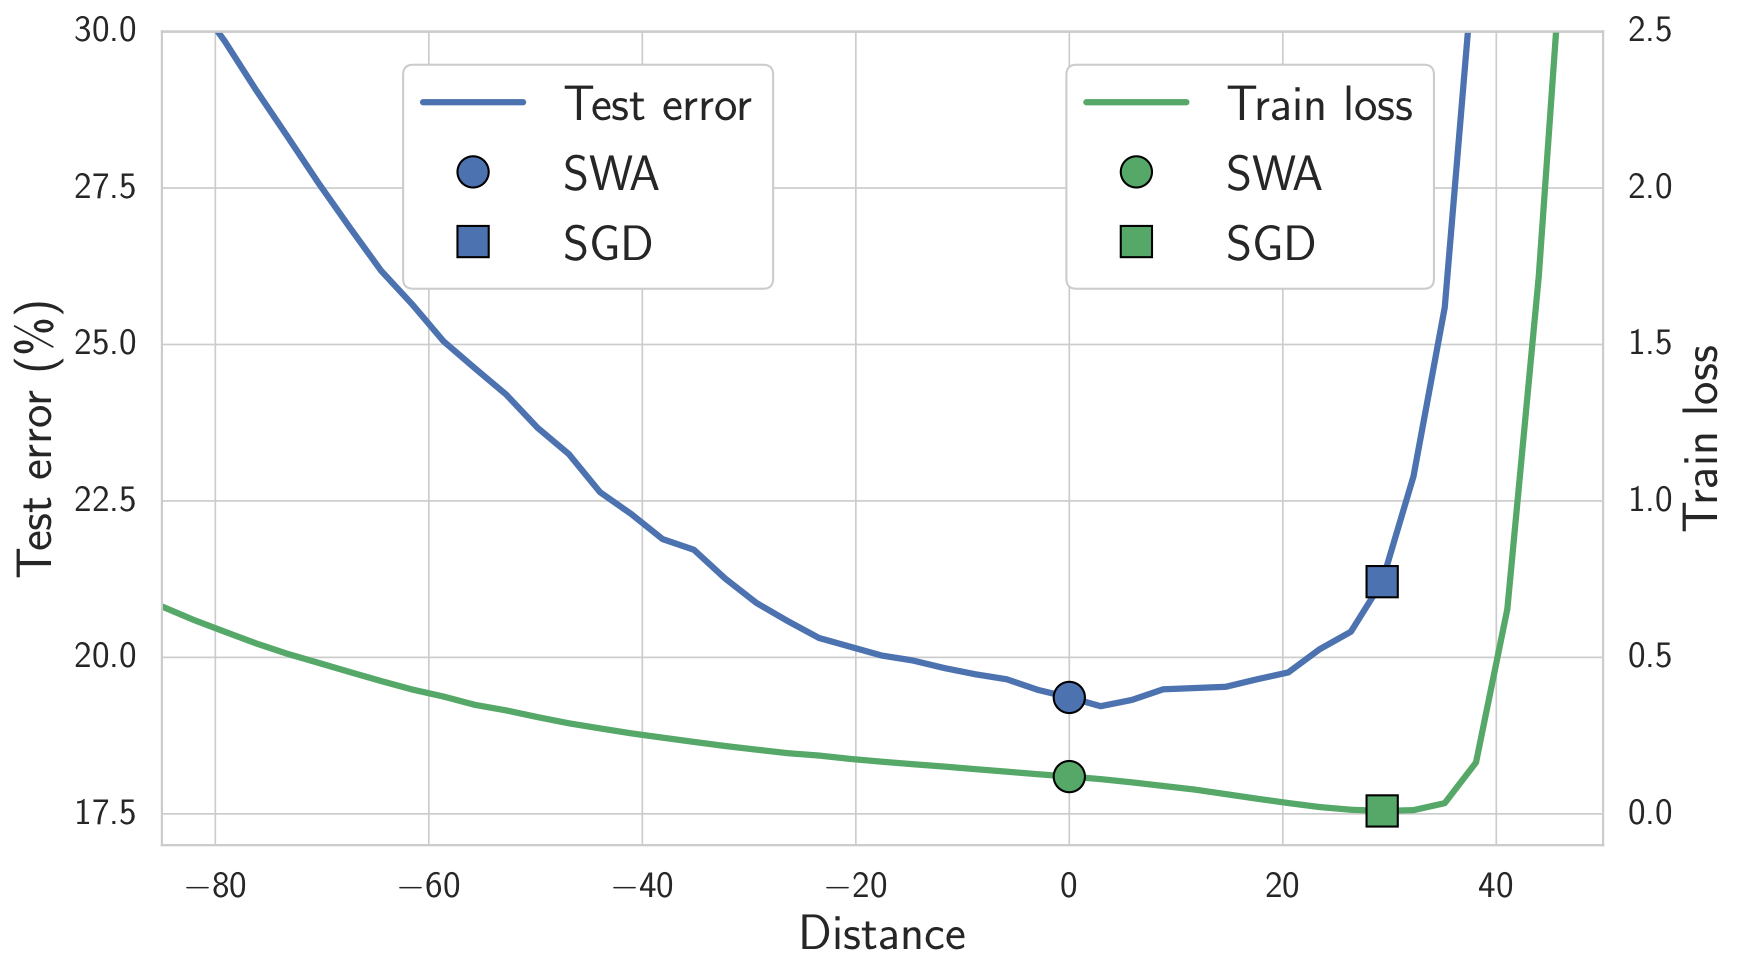

- We expect solutions that are centered in the flat region of the loss to generalize better than those near the boundary. 
- Indeed, **train and test error surfaces are not perfectly aligned** in the weight space. **Solutions that are centered in the flat region are not as susceptible to the shifts between train and test error surfaces.**

In [1]:
from torchcontrib.optim import SWA

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
import numpy as np

from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda:0")

In [3]:
# CIFAR10 dataset
cifar_train = datasets.CIFAR10(root='CIFAR10_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

cifar_test = datasets.CIFAR10(root='CIFAR10_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
epochs = 15
batch_size = 128

valid_ratio = 0.1

num_train = len(cifar_train)
indices = list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(valid_ratio * num_train))

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [5]:
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=cifar_train,
                                          batch_size=batch_size,
                                          sampler=train_sampler,
                                          drop_last=True)
valid_loader = torch.utils.data.DataLoader(dataset=cifar_train,
                                          batch_size=batch_size,
                                          sampler=valid_sampler,
                                          drop_last=True)

In [6]:
def vaild_loss(model_valid):
    avg_loss = 0
    with torch.no_grad():
        model_valid.eval()
        for images, labels in valid_loader:
            pred = model_valid(images.to(device))
            criterion = nn.CrossEntropyLoss().to(device)
            loss = criterion(pred, labels.to(device))
            avg_loss+= loss.item()
    
    return avg_loss / len(valid_loader)

In [7]:
import torchvision.models.vgg as vgg

In [8]:
cnn_config = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], #8 + 3 =11 == vgg11
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # 10 + 3 = vgg 13
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], #13 + 3 = vgg 16
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'], # 16 +3 =vgg 19
    'simplified' : [64,64,'M',128,128,'M',256,256,'M']
}

cnn_model = vgg.make_layers(cnn_config['simplified'])  #vgg16 Conv Module을 Load
print(cnn_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [9]:
class VGG(nn.Module):

    def __init__(self, cnn_features, num_classes=10, init_weights=True):
        super(VGG, self).__init__()
        self.cnn_features = cnn_features
        self.fc = nn.Sequential(
            nn.Linear(256*4*4, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )
        if init_weights:
            self._initialize_weights()
    
    def forward(self, x):
        out = self.cnn_features(x)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [10]:
vggnet= VGG(cnn_model,10,True).to(device)

##### SWA
 - SWA is implemented as a wrapper class taking optimizer instance as input and applying SWA on top of that optimizer.
    - swa_start (int): number of iterations before starting to apply SWA in automatic mode; if None, manual mode is selected 
    - swa_freq (int): number of iterations between subsequent updates of SWA running averages in automatic mode; if None, manual mode is selected 
    - swa_lr (float): learning rate to use starting from step swa_start in automatic mode; if None, learning rate is not changed

In [11]:
criterion = nn.CrossEntropyLoss().to(device)

base_optimizer = optim.Adam(vggnet.parameters(), lr=0.0001)
optimizer = SWA(base_optimizer, swa_start=4000, swa_freq=50, swa_lr=0.0005)
#  전체 50 epoch , len(train_loader) = 351. 전체 iternation 16,500번이니, 6500번부터 100번에 한번씩
#  총 100개 weight sample해서 SWA update.

In [12]:
total_batch = len(train_loader)
vggnet.train()
best_valid = np.inf

for epoch in range(50):
    avg_loss = 0

    for X, Y in train_loader:
        X = X.to(device) #img
        Y = Y.to(device) #label

        pred = vggnet(X)
        loss = criterion(pred, Y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss / total_batch
    
    loss_valid = vaild_loss(vggnet)    
    if loss_valid < best_valid:
        torch.save(vggnet.state_dict(), './saves/vggnet_cifar10.pth')
        best_valid = loss_valid
    if epoch%5==0:
        print('Epoch:{}, train loss:{:.5f}, valid loss:{:.5f}'.format(epoch, avg_loss, loss_valid))

Epoch:0, train loss:1.87949, valid loss:1.64924
Epoch:5, train loss:0.92822, valid loss:0.90721
Epoch:10, train loss:0.58230, valid loss:0.74790
Epoch:15, train loss:0.26944, valid loss:0.82889
Epoch:20, train loss:0.08199, valid loss:1.05939
Epoch:25, train loss:0.06288, valid loss:1.19587
Epoch:30, train loss:0.03979, valid loss:1.24216
Epoch:35, train loss:0.04306, valid loss:1.24087
Epoch:40, train loss:0.03228, valid loss:1.30524
Epoch:45, train loss:0.02453, valid loss:1.34839


- Accuracies of SWA, SGD methods on CIFAR-10 dataset
    - SWA improves generalization by 5%. 

In [13]:
test_loader = torch.utils.data.DataLoader(dataset=cifar_test, batch_size=128, shuffle=False)

In [14]:
correct = 0
total = 0
model_test = VGG(cnn_model,10,True).to(device)
model_test.load_state_dict(torch.load('./saves/vggnet_cifar10.pth'))

with torch.no_grad():
    model_test.eval()
    for images, labels in test_loader:
        output = model_test(images.to(device))
        _, predicted = torch.max(output, dim=1)        
        total += labels.size(0)
        correct += (predicted ==labels.to(device)).sum().item()

print('Best validation accuracy:', (correct / total))

Best validation accuracy: 0.7571


In [15]:
vggnet.train()
optimizer.swap_swa_sgd()

In [16]:
correct = 0
total = 0

with torch.no_grad():
    vggnet.eval()
    for images, labels in test_loader:
        output = vggnet(images.to(device))
        _, predicted = torch.max(output, dim=1)        
        total += labels.size(0)
        correct += (predicted ==labels.to(device)).sum().item()

print('SWA accuracy:', (correct / total))

SWA accuracy: 0.8088
